# Installations and downloads

In [1]:
# Uninstall problematic and conflicting packages
#!pip uninstall -y numpy scipy transformers accelerate sentence-transformers huggingface-hub tensorflow jax jaxlib

# Reinstall stable NumPy and SciPy versions compatible with transformers and torch
#!pip install numpy==1.24.3 scipy==1.10.1 --no-cache-dir

# Install required NLP libraries (latest compatible versions)
#!pip install transformers accelerate datasets evaluate scikit-learn --upgrade --no-cache-dir

In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 15.9 MB/s eta 0:00:00


In [2]:
# Download GloVe embeddings (100d)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-08-03 08:49:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-08-03 08:49:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-08-03 08:49:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
# Remove unused embeding sizes to save space
!rm glove.6B.50d.txt
!rm glove.6B.200d.txt
!rm glove.6B.300d.txt

# **Multi-class emotion classification**

## **Import libraries**

In [6]:
# -------
# System
# -------
import os
import warnings
warnings.filterwarnings("ignore")

# ----------------
# Core libraries
# ----------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------
# NLP tools
# ----------
import string
import contractions
import re
import nltk
import time
import random

# NLTK setup
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from collections import Counter
from wordcloud import WordCloud
from IPython.display import display, HTML
from tabulate import tabulate

# spaCy setup
import spacy
import en_core_web_sm

try:
  spacy.require_gpu()
  print("spaCy: GPU is available")
except Exception as e:
  print("spaCy: GPU is not available")

nlp = en_core_web_sm.load(disable=["parser", "ner"])

# -------------------------
# Traditional ML libraries
# -------------------------
from sklearn.feature_extraction.text import (TfidfVectorizer, CountVectorizer)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import (LabelEncoder, StandardScaler)
from sklearn.svm import (SVC, LinearSVC)
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

# -------------------------
# Deep learning - Keras
# -------------------------
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, Bidirectional, LSTM, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
from tensorflow.keras.utils import to_categorical

# ----------------------
# Deep learning - PyTorch
# ----------------------
import torch
import torch.nn as nn
from torch.utils.data import (Dataset, DataLoader)

# -------------
# Transformers
# -------------
from sentence_transformers import SentenceTransformer
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    set_seed
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


spaCy: GPU is available


## **Load dataset**

In [7]:
df_emotion = pd.read_csv('combined_emotion.csv')

# Preview
print("Shape:", df_emotion.shape)
df_emotion.head()

Shape: (422746, 2)


,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear


##**Exploratory data analysis (EDA)**

### Basic data info

In [7]:
# Basic info
df_emotion.info()

# Check for missing values
print("\nMissing values:\n", df_emotion.isnull().sum())

# Unique emotion labels
print("\nUnique emotion classes:", df_emotion['emotion'].unique())
print("\nEmotion counts:\n", df_emotion['emotion'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422746 entries, 0 to 422745
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  422746 non-null  object
 1   emotion   422746 non-null  object
dtypes: object(2)
memory usage: 6.5+ MB

Missing values:
 sentence    0
emotion     0
dtype: int64

Unique emotion classes: ['fear' 'sad' 'love' 'joy' 'suprise' 'anger']

Emotion counts:
 emotion
joy        143067
sad        121187
anger       59317
fear        49649
love        34554
suprise     14972
Name: count, dtype: int64


### Class distribution

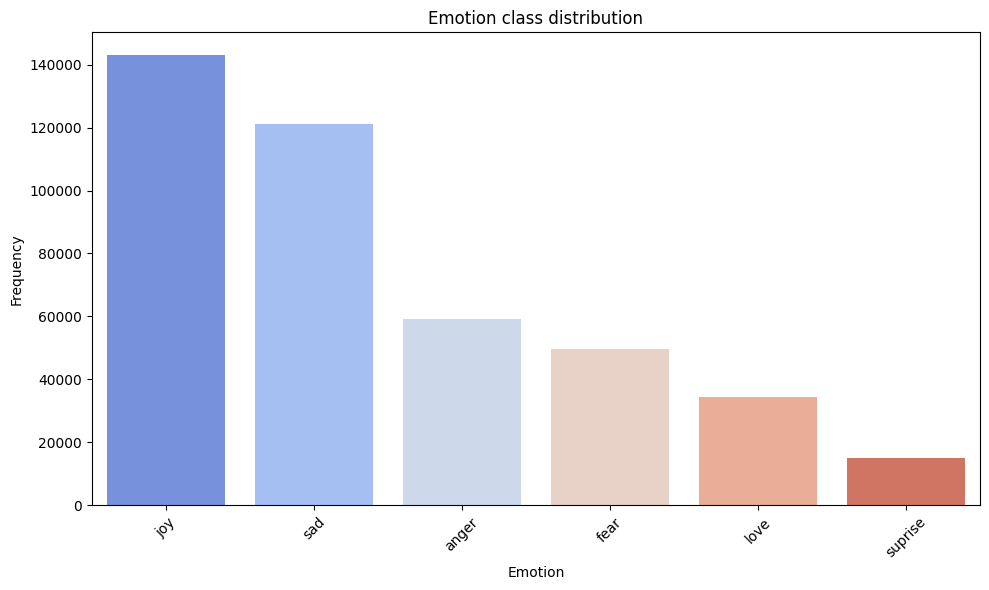

In [8]:
# Class distribution plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_emotion, x='emotion', order=df_emotion['emotion'].value_counts().index, palette='coolwarm')
plt.title("Emotion class distribution")
plt.ylabel("Frequency")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sentence length analysis

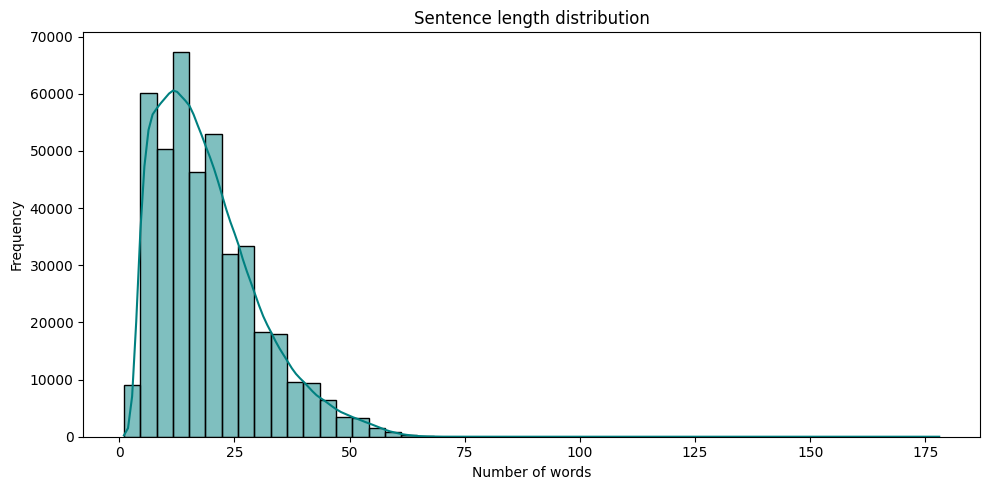

,text_length
count,422746.000000
mean,19.211612
std,11.051310
min,1.000000
25%,11.000000
50%,17.000000
75%,25.000000
max,178.000000


In [9]:
# Sentence length (in words)
df_emotion['text_length'] = df_emotion['sentence'].apply(lambda x: len(str(x).split()))

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_emotion['text_length'], bins=50, kde=True, color='teal')
plt.title("Sentence length distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Summary stats
df_emotion['text_length'].describe()

### Most frequent words per emotion

In [10]:
# Stopwords
stop_words = set(stopwords.words("english"))

# Top words per emotion
def get_top_words_per_emotion(df, label_col="emotion", text_col="sentence", top_n=10):
    top_words = {}
    grouped = df.groupby(label_col)

    for emotion, group in grouped:
        all_words = " ".join(group[text_col].astype(str)).lower()
        tokens = [word for word in re.findall(r'\b\w+\b', all_words) if word not in stop_words]
        top_words[emotion] = Counter(tokens).most_common(top_n)

    return top_words

top_words_emotion = get_top_words_per_emotion(df_emotion)

# Print top words per emotion
for emo, words in top_words_emotion.items():
    print(f"\nTop words for {emo}:")
    print(", ".join([f"{w} ({c})" for w, c in words]))


Top words for anger:
feel (39072), feeling (19905), like (10722), im (9619), really (3884), know (3505), get (3455), people (3172), time (3046), little (2920)

Top words for fear:
feel (32125), feeling (18415), im (7872), like (6518), little (3667), know (3157), really (2900), bit (2541), time (2501), still (2474)

Top words for joy:
feel (104189), feeling (41506), like (25624), im (20745), really (8616), time (7425), know (7251), get (6622), would (5981), people (5874)

Top words for love:
feel (24463), feeling (10303), like (7558), im (4775), love (2365), really (2247), know (2077), people (1705), would (1694), time (1690)

Top words for sad:
feel (84184), feeling (40849), like (22167), im (17631), really (7533), know (7183), time (6133), little (5719), get (5410), ive (5172)

Top words for suprise:
feel (9953), feeling (5171), like (2375), im (1963), amazed (1415), impressed (1414), weird (1413), strange (1400), overwhelmed (1391), surprised (1389)


### Word cloud per emotion

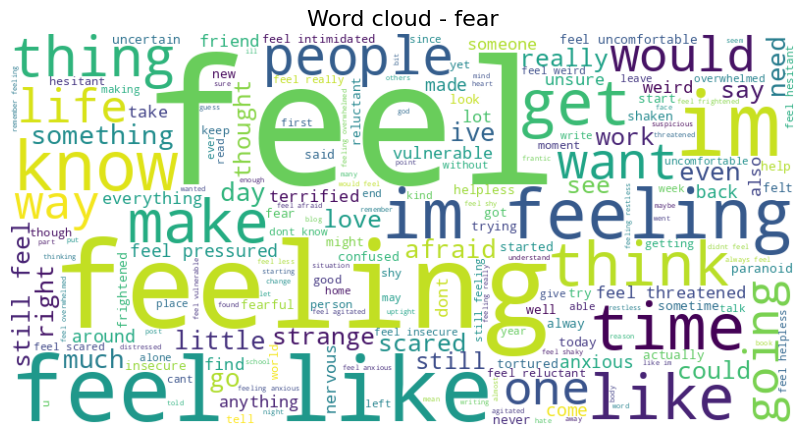

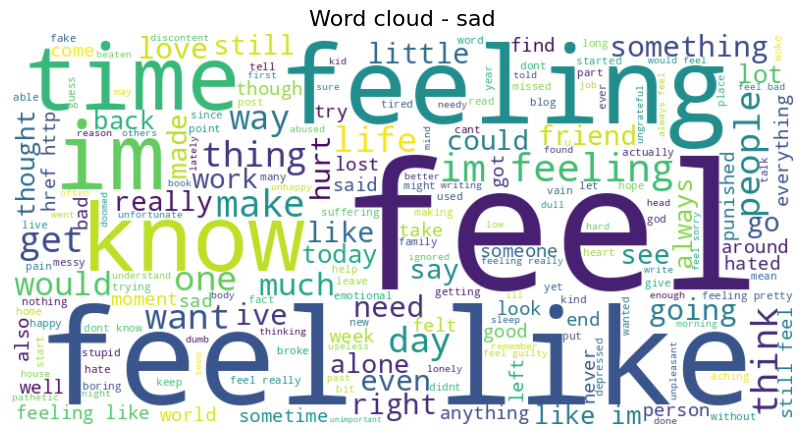

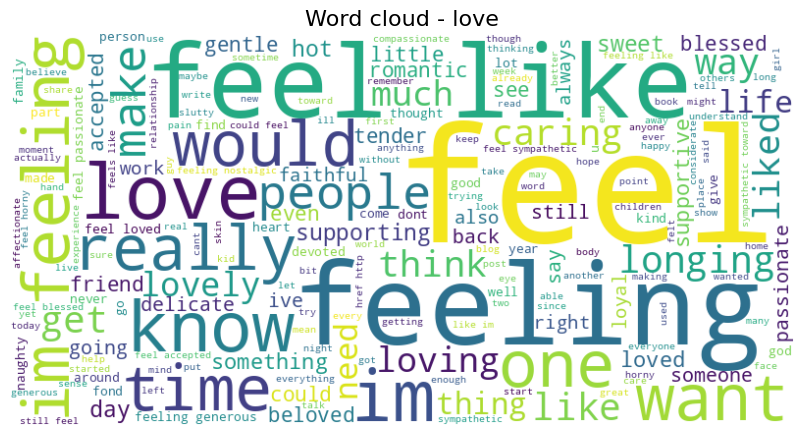

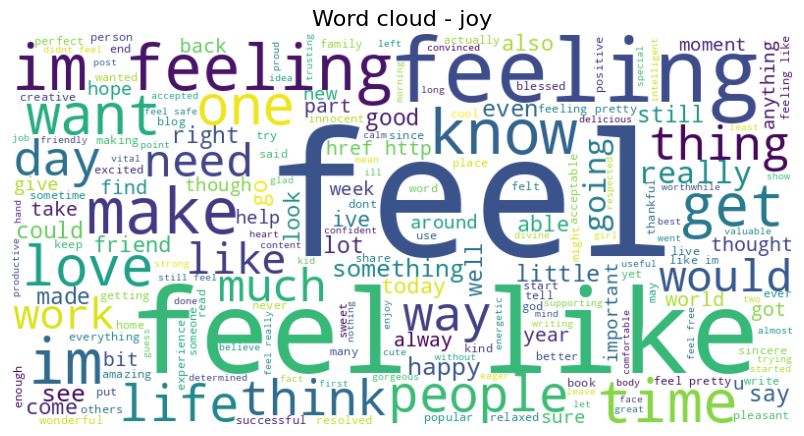

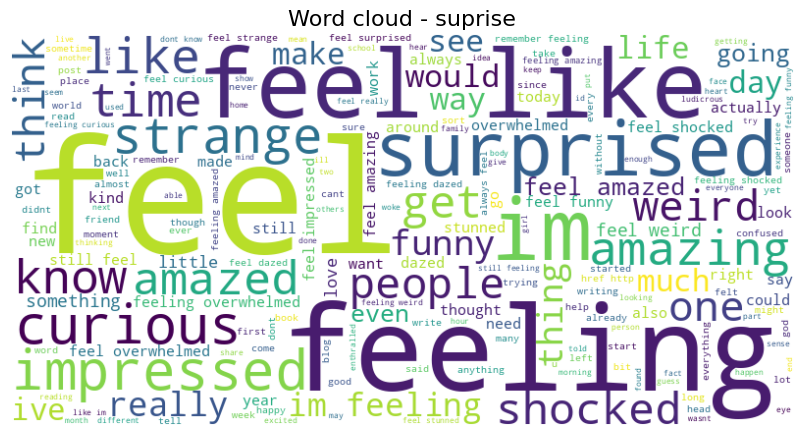

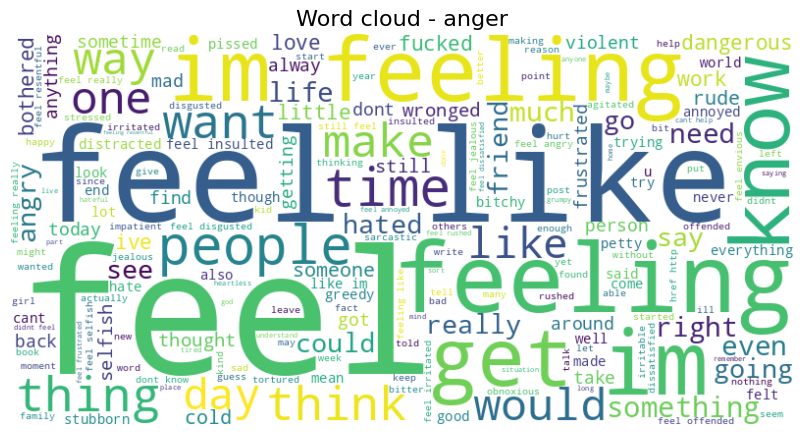

In [11]:
for emotion in df_emotion['emotion'].unique():
    subset = df_emotion[df_emotion['emotion'] == emotion]
    text = " ".join(subset['sentence'].astype(str)).lower()

    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word cloud - {emotion}", fontsize=16)
    plt.tight_layout(pad=3)
    plt.show()

    # Add vertical spacing (~1 cm visually)
    display(HTML("<div style='margin: 30px 0;'></div>"))

### Sentence length by emotion

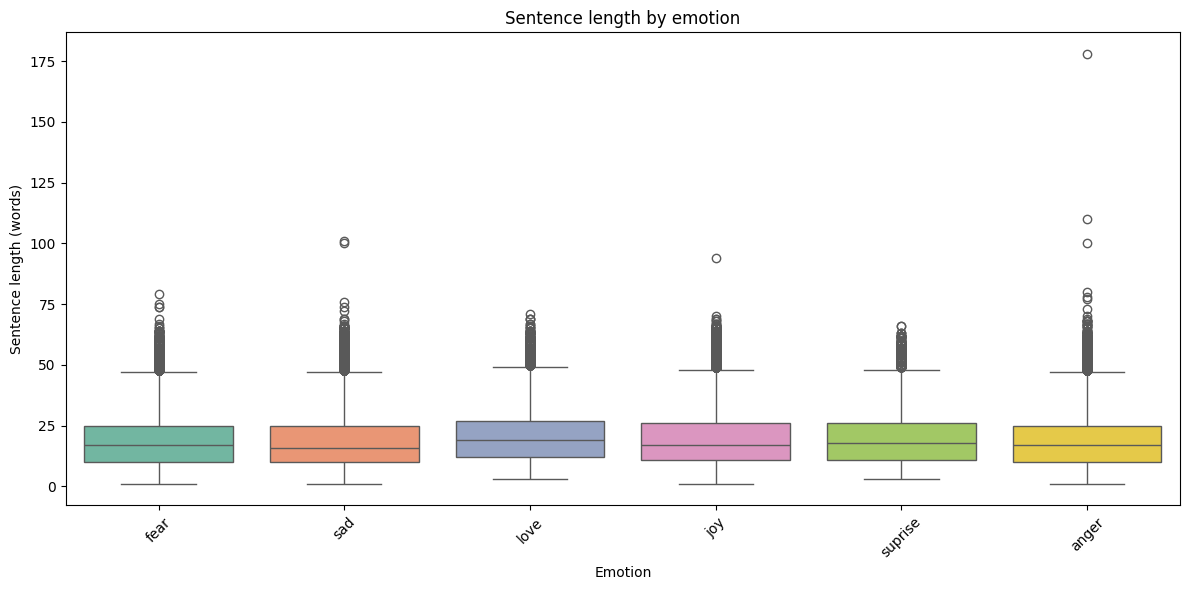

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_emotion, x="emotion", y="text_length", palette="Set2")
plt.title("Sentence length by emotion")
plt.xlabel("Emotion")
plt.ylabel("Sentence length (words)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##**Preprocessing**

### Basic text cleaning

In [8]:
def clean_text(text):
  # Expand contractions
  text = contractions.fix(text)

  # Lowercase
  text = str(text).lower()

  # Remove URLs, mentions, hashtags
  text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)

  # Remove punctuation and numbers
  text = re.sub(r"[^a-z\s]", "", text)

  # Remove extra spaces
  text = re.sub(r"\s+", " ", text).strip()

  return text

### Lemmatization function

In [9]:
def fast_lemmatize_texts(texts, stop_words):
    lemmatized_texts = []
    for doc in nlp.pipe(texts, batch_size=500):
        tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stop_words]
        lemmatized_texts.append(" ".join(tokens))
    return lemmatized_texts

### Apply preprocessing

In [10]:
# Apply cleaning
df_emotion["clean_text"] = df_emotion["sentence"].apply(clean_text)

# Apply lemmatization
texts = df_emotion["clean_text"].astype(str).tolist()
df_emotion["lemmatized"] = fast_lemmatize_texts(texts, stop_words)

In [11]:
# Check preprocessing by showing some examples where original != cleaned
df_emotion[df_emotion["emotion"] != df_emotion["clean_text"]][["sentence", "clean_text"]].head()

,sentence,clean_text
0,i just feel really helpless and heavy hearted,i just feel really helpless and heavy hearted
1,ive enjoyed being able to slouch about relax a...,i have enjoyed being able to slouch about rela...
2,i gave up my internship with the dmrg and am f...,i gave up my internship with the dmrg and am f...
3,i dont know i feel so lost,i do not know i feel so lost
4,i am a kindergarten teacher and i am thoroughl...,i am a kindergarten teacher and i am thoroughl...


### Encode labels

In [12]:
le = LabelEncoder()
df_emotion['label'] = le.fit_transform(df_emotion['emotion'])

# Check label mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
label_mapping_clean = {k: int(v) for k, v in label_mapping.items()}
print("Label mapping:", label_mapping_clean)

Label mapping: {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sad': 4, 'suprise': 5}


### Create deep learning (DL) and balanced machine learning (ML) datasets

In [13]:
# For DL (keep full dataset)
df_emotion_dl = df_emotion.copy()

# For traditional ML (balanced)
balanced_frames = []
min_size = df_emotion["emotion"].value_counts().min()

for emotion in df_emotion["emotion"].unique():
    subset = df_emotion[df_emotion["emotion"] == emotion]
    balanced_subset = resample(subset, replace=False, n_samples=min_size, random_state=42)
    balanced_frames.append(balanced_subset)

df_emotion_ml = pd.concat(balanced_frames).sample(frac=1, random_state=42).reset_index(drop=True)

# Checks
head_dl = df_emotion_dl.head()
head_ml = df_emotion_ml.head()

print("DL dataset head:")
display(head_dl)

print("\nML dataset head:")
display(head_ml)

shape_dl = df_emotion_dl.shape
shape_ml = df_emotion_ml.shape

print("DL dataset shape:", shape_dl)
print("ML dataset shape:", shape_ml)

DL dataset head:


,sentence,emotion,clean_text,lemmatized,label
0,i just feel really helpless and heavy hearted,fear,i just feel really helpless and heavy hearted,feel really helpless heavy hearted,1
1,ive enjoyed being able to slouch about relax a...,sad,i have enjoyed being able to slouch about rela...,enjoy able slouch relax unwind frankly need la...,4
2,i gave up my internship with the dmrg and am f...,fear,i gave up my internship with the dmrg and am f...,give internship dmrg feel distraught,1
3,i dont know i feel so lost,sad,i do not know i feel so lost,know feel lost,4
4,i am a kindergarten teacher and i am thoroughl...,fear,i am a kindergarten teacher and i am thoroughl...,kindergarten teacher thoroughly weary job take...,1



ML dataset head:


,sentence,emotion,clean_text,lemmatized,label
0,i can t help but feel like all of my problems ...,anger,i can t help but feel like all of my problems ...,help feel like problem petty little people go ...,0
1,i feel like a shitty person im not going to ha...,sad,i feel like a shitty person i am not going to ...,feel like shitty person go good time,4
2,i knew i just really needed to do something to...,joy,i knew i just really needed to do something to...,know really need something get house feel prod...,2
3,i climbed out my window to meet them feeling r...,anger,i climbed out my window to meet them feeling r...,climb window meet feel rebellious,0
4,i have a feeling he has been distracted by tal...,anger,i have a feeling he has been distracted by tal...,feeling distract talk fight next apprentice cl...,0


DL dataset shape: (422746, 5)
ML dataset shape: (89832, 5)


### Clean up

In [14]:
# After adding lemmatized and label columns:
df_emotion_ml = df_emotion_ml[["lemmatized", "label"]].copy()
df_emotion_dl = df_emotion_dl[["clean_text", "lemmatized", "label"]].copy()

## **Vectorization**

### Train-test split

In [15]:
# Features and labels
X = df_emotion_ml["lemmatized"]
y = df_emotion_ml["label"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Bag of Words (BoW)

In [16]:
# Initialize BoW vectorizer
bow_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2))

# Fit-transform on training set and transform on test set
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

### TF-IDF

In [17]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 2), analyzer='word')

# Fit-transform on training set and transform on test set
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### SBERT

In [18]:
# Load pretrained SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode training and test sets
X_train_sbert = sbert_model.encode(X_train.tolist(), show_progress_bar=True)
X_test_sbert = sbert_model.encode(X_test.tolist(), show_progress_bar=True)

# Apply feature scaling
scaler = StandardScaler()
X_train_sbert_scaled = scaler.fit_transform(X_train_sbert)
X_test_sbert_scaled = scaler.transform(X_test_sbert)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2246 [00:00<?, ?it/s]

Batches:   0%|          | 0/562 [00:00<?, ?it/s]

## **Traditional machine learning (ML) models**

### Linear Support Vector Classifier (BoW, TF-IDF, SBERT)

In [19]:
# Store results
svm_results = []

def evaluate_svm_model(X_train_vec, X_test_vec, vec_name):
    start = time.time()

    # Define parameter grid for C
    param_grid = {
        'C': [0.1, 1, 10]
    }

    # GridSearch with LinearSVC
    grid = GridSearchCV(
        LinearSVC(max_iter=10000),
        param_grid=param_grid,
        scoring='f1_macro',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_vec, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_vec)

    end = time.time()
    elapsed_time = round(end - start, 2)

    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Print results
    print(f"\nLinearSVC with {vec_name}")
    print("Best params:", grid.best_params_)
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"Time:      {elapsed_time} seconds")
    print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    # Append to results
    svm_results.append({
        "Model": "LinearSVC",
        "Vectorization": vec_name,
        "F1": round(f1, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "Accuracy": round(acc, 4),
        "Time (s)": elapsed_time
    })

    return y_pred, best_model

# Run for TF-IDF
svm_tfidf_preds, best_svm_model_tfidf = evaluate_svm_model(X_train_tfidf, X_test_tfidf, "TF-IDF")

# Run for BoW
svm_bow_preds, best_svm_model_bow = evaluate_svm_model(X_train_bow, X_test_bow, "BoW")

# Run for SBERT (scaled)
svm_sbert_preds, best_svm_model_sbert = evaluate_svm_model(X_train_sbert_scaled, X_test_sbert_scaled, "SBERT (scaled)")

Fitting 3 folds for each of 3 candidates, totalling 9 fits

LinearSVC with TF-IDF
Best params: {'C': 0.1}
Accuracy:  0.9219
Precision: 0.9229
Recall:    0.9219
F1-score:  0.9216
Time:      7.11 seconds

Classification report:
               precision    recall  f1-score   support

       anger       0.93      0.94      0.93      2994
        fear       0.93      0.86      0.89      2994
         joy       0.94      0.88      0.91      2995
        love       0.90      0.95      0.93      2995
         sad       0.95      0.91      0.93      2995
     suprise       0.90      0.98      0.94      2994

    accuracy                           0.92     17967
   macro avg       0.92      0.92      0.92     17967
weighted avg       0.92      0.92      0.92     17967

Fitting 3 folds for each of 3 candidates, totalling 9 fits

LinearSVC with BoW
Best params: {'C': 0.1}
Accuracy:  0.9163
Precision: 0.9167
Recall:    0.9163
F1-score:  0.9159
Time:      16.33 seconds

Classification report:
      

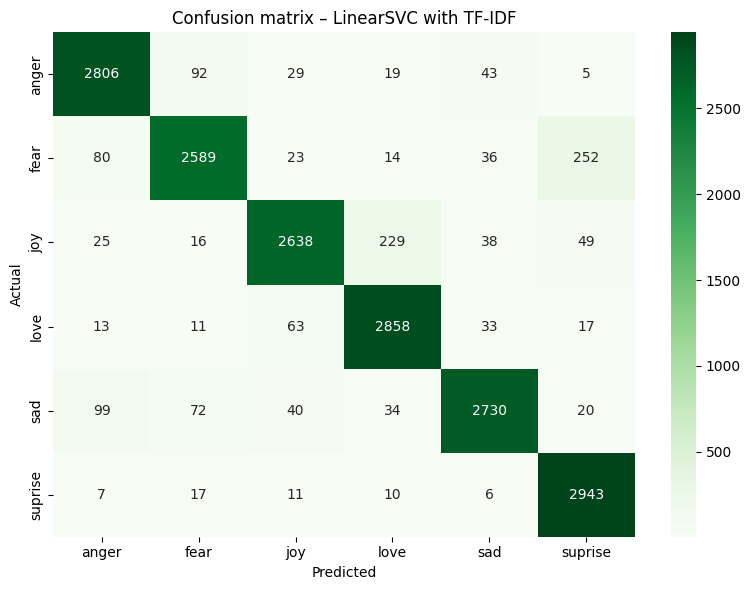

In [20]:
# Compute confusion matrix for LinearSVC with TF-IDF
cm = confusion_matrix(y_test, svm_tfidf_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix – LinearSVC with TF-IDF")
plt.tight_layout()
plt.show()

### Logistic Regression (BoW, TF-IDF, SBERT)

In [21]:
# Store results for summary table
lr_results = []

# Define a function to train, evaluate, and collect results
def evaluate_lr_model(X_train_vec, X_test_vec, vec_name):
    start = time.time()

    # Hyperparameter grid
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

    # Grid search with Logistic Regression
    grid = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid=param_grid,
        scoring='f1_macro',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_vec, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_vec)

    end = time.time()
    elapsed_time = round(end - start, 2)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"\nLogistic Regression with {vec_name}")
    print("Best params:", grid.best_params_)
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"Time:      {elapsed_time} seconds")
    print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    lr_results.append({
        "Model": "Logistic Regression",
        "Vectorization": vec_name,
        "F1": round(f1, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "Accuracy": round(acc, 4),
        "Time (s)": elapsed_time
    })

    return y_pred

# Run for BoW
lr_bow_preds = evaluate_lr_model(X_train_bow, X_test_bow, "BoW")

# Run for TF-IDF
lr_tfidf_preds = evaluate_lr_model(X_train_tfidf, X_test_tfidf, "TF-IDF")

# Run for SBERT (scaled)
lr_sbert_preds = evaluate_lr_model(X_train_sbert_scaled, X_test_sbert_scaled, "SBERT (scaled)")

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Logistic Regression with BoW
Best params: {'C': 0.1}
Accuracy:  0.9135
Precision: 0.9142
Recall:    0.9135
F1-score:  0.9131
Time:      22.24 seconds

Classification report:
               precision    recall  f1-score   support

       anger       0.92      0.93      0.92      2994
        fear       0.92      0.85      0.89      2994
         joy       0.91      0.88      0.90      2995
        love       0.90      0.94      0.92      2995
         sad       0.94      0.90      0.92      2995
     suprise       0.89      0.98      0.94      2994

    accuracy                           0.91     17967
   macro avg       0.91      0.91      0.91     17967
weighted avg       0.91      0.91      0.91     17967

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Logistic Regression with TF-IDF
Best params: {'C': 1}
Accuracy:  0.9130
Precision: 0.9134
Recall:    0.9130
F1-score:  0.9127
Time:      34.57 seconds

Classifi

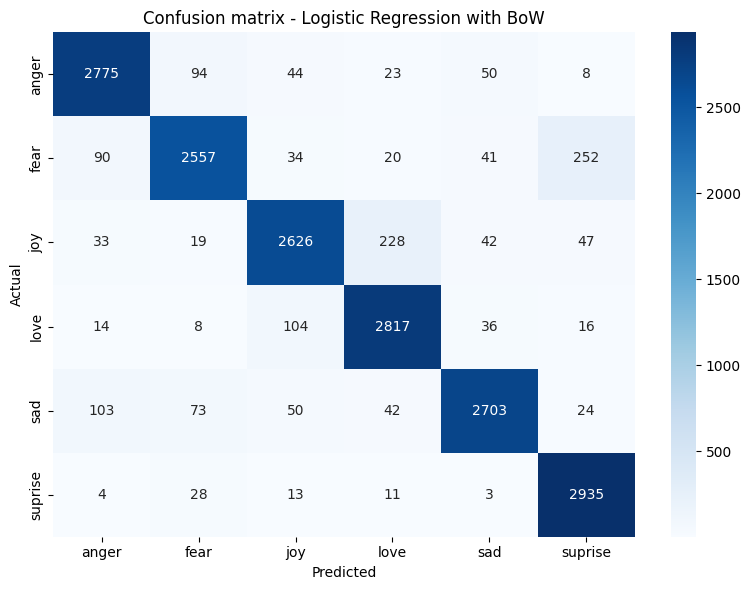

In [22]:
# Compute confusion matrix for logistic regression with BoW
cm = confusion_matrix(y_test, lr_bow_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix - Logistic Regression with BoW")
plt.tight_layout()
plt.show()

### Naive Bayes (BoW, TF-IDF)

In [23]:
# Store results for summary table
nb_results = []

def evaluate_nb_model(X_train_vec, X_test_vec, vec_name):
    start = time.time()

    param_grid = {'alpha': [0.01, 0.1, 1, 5, 10]}
    grid = GridSearchCV(MultinomialNB(), param_grid, scoring='f1_macro', cv=3, n_jobs=-1, verbose=1)
    grid.fit(X_train_vec, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_vec)

    end = time.time()
    elapsed_time = round(end - start, 2)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"\nNaive Bayes with {vec_name}")
    print("Best alpha:", grid.best_params_['alpha'])
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"Time:      {elapsed_time} seconds")
    print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    nb_results.append({
        "Model": "Naive Bayes",
        "Vectorization": vec_name,
        "F1": round(f1, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "Accuracy": round(acc, 4),
        "Time (s)": elapsed_time
    })

    return y_pred

# Run for BoW
nb_bow_preds = evaluate_nb_model(X_train_bow, X_test_bow, "BoW")

# Run for TF-IDF
nb_tfidf_preds = evaluate_nb_model(X_train_tfidf, X_test_tfidf, "TF-IDF")

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Naive Bayes with BoW
Best alpha: 5
Accuracy:  0.8925
Precision: 0.8936
Recall:    0.8925
F1-score:  0.8921
Time:      0.25 seconds

Classification report:
               precision    recall  f1-score   support

       anger       0.91      0.91      0.91      2994
        fear       0.89      0.84      0.87      2994
         joy       0.90      0.83      0.87      2995
        love       0.86      0.93      0.89      2995
         sad       0.92      0.88      0.90      2995
     suprise       0.88      0.96      0.92      2994

    accuracy                           0.89     17967
   macro avg       0.89      0.89      0.89     17967
weighted avg       0.89      0.89      0.89     17967

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Naive Bayes with TF-IDF
Best alpha: 5
Accuracy:  0.8983
Precision: 0.8998
Recall:    0.8983
F1-score:  0.8980
Time:      0.24 seconds

Classification report:
               precis

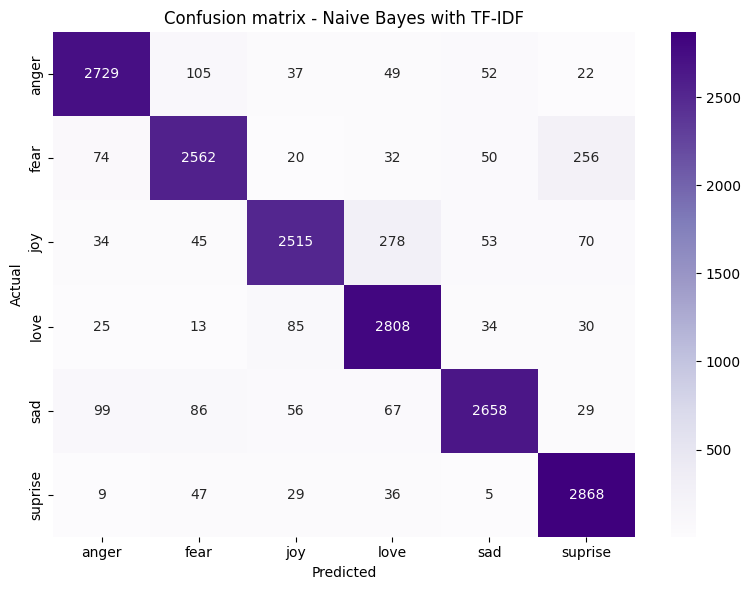

In [24]:
# Compute confusion matrix for Naive Bayes with TF-IDF
cm = confusion_matrix(y_test, nb_tfidf_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix - Naive Bayes with TF-IDF")
plt.tight_layout()
plt.show()

### Performance summary: Traditional ML models (BoW, TF-IDF, SBERT)

In [25]:
# Fill in 'SBERT' for NB as N/A (if not already included)
nb_results.append({
    "Model": "Naive Bayes",
    "Vectorization": "SBERT (scaled)",
    "F1": "N/A",
    "Precision": "N/A",
    "Recall": "N/A",
    "Accuracy": "N/A",
    "Time (s)": "N/A"
})

In [26]:
# Combine all results
all_model_results = svm_results + lr_results + nb_results

# Create DataFrame
results_df = pd.DataFrame(all_model_results)

# Optional: sort for easier viewing
results_df = results_df.sort_index()

# Display as markdown-style table (clean for reports)
print(tabulate(results_df, headers='keys', tablefmt='github'))

|    | Model               | Vectorization   | F1     | Precision   | Recall   | Accuracy   | Time (s)   |
|----|---------------------|-----------------|--------|-------------|----------|------------|------------|
|  0 | LinearSVC           | TF-IDF          | 0.9216 | 0.9229      | 0.9219   | 0.9219     | 7.11       |
|  1 | LinearSVC           | BoW             | 0.9159 | 0.9167      | 0.9163   | 0.9163     | 16.33      |
|  2 | LinearSVC           | SBERT (scaled)  | 0.6849 | 0.6855      | 0.6865   | 0.6865     | 149.11     |
|  3 | Logistic Regression | BoW             | 0.9131 | 0.9142      | 0.9135   | 0.9135     | 22.24      |
|  4 | Logistic Regression | TF-IDF          | 0.9127 | 0.9134      | 0.913    | 0.913      | 34.57      |
|  5 | Logistic Regression | SBERT (scaled)  | 0.6858 | 0.6856      | 0.6865   | 0.6865     | 25.78      |
|  6 | Naive Bayes         | BoW             | 0.8921 | 0.8936      | 0.8925   | 0.8925     | 0.25       |
|  7 | Naive Bayes         | TF-IDF  

## **Multilayer Perceptron (MLP) with SBERT (scaled)**

### Model with Keras

In [27]:
# One-hot encode labels
num_classes = len(le.classes_)
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Build MLP model
mlp_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_sbert_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
start = time.time()
history = mlp_model.fit(X_train_sbert_scaled, y_train_oh,
                        epochs=30,
                        batch_size=32,
                        validation_split=0.1,
                        callbacks=callbacks,
                        verbose=1)
end = time.time()
elapsed_time = round(end - start, 2)

Epoch 1/30
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5447 - loss: 1.2678 - val_accuracy: 0.7209 - val_loss: 0.7568 - learning_rate: 0.0010
Epoch 2/30
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6950 - loss: 0.8202 - val_accuracy: 0.7366 - val_loss: 0.7146 - learning_rate: 0.0010
Epoch 3/30
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7252 - loss: 0.7402 - val_accuracy: 0.7425 - val_loss: 0.6843 - learning_rate: 0.0010
Epoch 4/30
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7419 - loss: 0.6961 - val_accuracy: 0.7565 - val_loss: 0.6589 - learning_rate: 0.0010
Epoch 5/30
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7582 - loss: 0.6522 - val_accuracy: 0.7623 - val_loss: 0.6357 - learning_rate: 0.0010
Epoch 6/30
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7731 - loss: 0.6145 - val_accuracy: 0.7604 - val_loss: 0.6334 - learning_rate: 0.0010
Epoch 7/30
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7797 - 

### Evaluate and store

In [28]:
# Initialize result list if not already done
mlp_results = []

def evaluate_mlp_model(y_true, y_pred_probs, elapsed_time):
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_true, y_pred_labels)
    prec = precision_score(y_true, y_pred_labels, average='macro')
    rec = recall_score(y_true, y_pred_labels, average='macro')
    f1 = f1_score(y_true, y_pred_labels, average='macro')

    print("MLP with SBERT (scaled)")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"Time:      {elapsed_time} seconds\n")
    print("Classification Report:\n", classification_report(y_true, y_pred_labels, target_names=le.classes_))

    mlp_results.append({
        "Model": "MLP",
        "Vectorization": "SBERT (scaled)",
        "F1": round(f1, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "Accuracy": round(acc, 4),
        "Time (s)": elapsed_time
    })

    return y_pred_labels

# Predict after training
y_pred_probs = mlp_model.predict(X_test_sbert_scaled)

# Evaluate and store results
y_pred_mlp = evaluate_mlp_model(y_test, y_pred_probs, elapsed_time)

562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MLP with SBERT (scaled)
Accuracy:  0.7822
Precision: 0.7820
Recall:    0.7822
F1-score:  0.7806
Time:      76.8 seconds

Classification Report:
               precision    recall  f1-score   support

       anger       0.77      0.84      0.80      2994
        fear       0.79      0.75      0.77      2994
         joy       0.77      0.67      0.71      2995
        love       0.78      0.83      0.80      2995
         sad       0.78      0.74      0.76      2995
     suprise       0.80      0.88      0.84      2994

    accuracy                           0.78     17967
   macro avg       0.78      0.78      0.78     17967
weighted avg       0.78      0.78      0.78     17967



### Confusion matrix

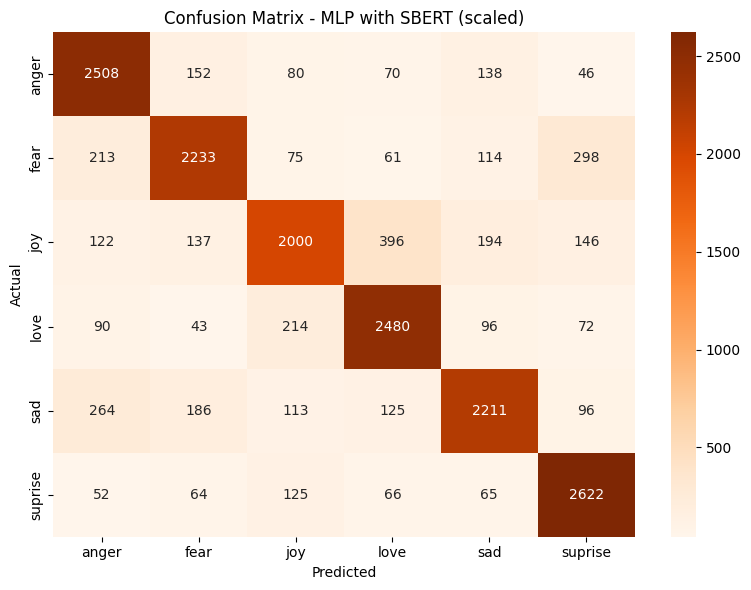

In [29]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MLP with SBERT (scaled)")
plt.tight_layout()
plt.show()

## **BiLSTM + GloVe**

### Tokenization and padding

In [30]:
# Parameters
vocab_size = 15000
max_len = 100
embedding_dim = 100

# Tokenization and padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<00>")
tokenizer.fit_on_texts(df_emotion_dl["lemmatized"])
X_seq = tokenizer.texts_to_sequences(df_emotion_dl["lemmatized"])
X_pad = pad_sequences(X_seq, maxlen=max_len, padding="post", truncating="post")
y_lstm = df_emotion_dl["label"].values

### Train-test split (stratified)

In [31]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_pad, y_lstm, test_size=0.2, stratify=y_lstm, random_state=42
)

### Load GloVe embeddings

In [32]:
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Build the BiLSTM model

In [33]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_len, trainable=False),
    Bidirectional(LSTM(128, dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_mapping), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy'])

print("Model before training:")
model.summary()

Model before training:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,500,000 (5.72 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,500,000 (5.72 MB)

### Train the model

In [34]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
start_train = time.time()
history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.1,
    epochs=30,
    batch_size=128,
    callbacks=[early_stop],
    verbose=2,
)
train_time = round(time.time() - start_train, 2)

print("Model after training:")
model.summary()

Epoch 1/30
2378/2378 - 31s - 13ms/step - accuracy: 0.7783 - loss: 0.6138 - val_accuracy: 0.8855 - val_loss: 0.2849
Epoch 2/30
2378/2378 - 26s - 11ms/step - accuracy: 0.8941 - loss: 0.2667 - val_accuracy: 0.9094 - val_loss: 0.2063
Epoch 3/30
2378/2378 - 26s - 11ms/step - accuracy: 0.9076 - loss: 0.2122 - val_accuracy: 0.9116 - val_loss: 0.1884
Epoch 4/30
2378/2378 - 26s - 11ms/step - accuracy: 0.9140 - loss: 0.1877 - val_accuracy: 0.9177 - val_loss: 0.1746
Epoch 5/30
2378/2378 - 26s - 11ms/step - accuracy: 0.9178 - loss: 0.1720 - val_accuracy: 0.9193 - val_loss: 0.1679
Epoch 6/30
2378/2378 - 26s - 11ms/step - accuracy: 0.9209 - loss: 0.1610 - val_accuracy: 0.9231 - val_loss: 0.1564
Epoch 7/30
2378/2378 - 26s - 11ms/step - accuracy: 0.9230 - loss: 0.1532 - val_accuracy: 0.9230 - val_loss: 0.1529
Epoch 8/30
2378/2378 - 26s - 11ms/step - accuracy: 0.9247 - loss: 0.1465 - val_accuracy: 0.9255 - val_loss: 0.1526
Epoch 9/30
2378/2378 - 26s - 11ms/step - accuracy: 0.9263 - loss: 0.1411 - val_a

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,254,004 (8.60 MB)

 Trainable params: 251,334 (981.77 KB)

 Non-trainable params: 1,500,000 (5.72 MB)

 Optimizer params: 502,670 (1.92 MB)

### Evaluate and report

In [35]:
# Predict
y_pred_lstm = model.predict(X_test_lstm)
y_pred_lstmlabels = np.argmax(y_pred_lstm, axis=1)

# Evaluation metrics
f1 = f1_score(y_test_lstm, y_pred_lstmlabels, average='macro')
prec = precision_score(y_test_lstm, y_pred_lstmlabels, average='macro')
rec = recall_score(y_test_lstm, y_pred_lstmlabels, average='macro')
acc = accuracy_score(y_test_lstm, y_pred_lstmlabels)

# Print results
print(f"\nBiLSTM with GloVe (100d)")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Time:      {train_time} seconds")
print("\nClassification Report:\n", classification_report(y_test_lstm, y_pred_lstmlabels, target_names=le.classes_))

# Save results for summary
lstm_results = []
lstm_results.append({
    "Model": "BiLSTM",
    "Vectorization": "GloVe (100d)",
    "F1": round(f1, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4),
    "Accuracy": round(acc, 4),
    "Time (s)": train_time
})

2643/2643 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step

BiLSTM with GloVe (100d)
Accuracy:  0.9248
Precision: 0.8866
Recall:    0.9022
F1-score:  0.8918
Time:      345.19 seconds

Classification Report:
               precision    recall  f1-score   support

       anger       0.93      0.93      0.93     11863
        fear       0.86      0.93      0.90      9930
         joy       0.97      0.91      0.94     28614
        love       0.75      0.95      0.84      6911
         sad       0.97      0.95      0.96     24238
     suprise       0.83      0.75      0.79      2994

    accuracy                           0.92     84550
   macro avg       0.89      0.90      0.89     84550
weighted avg       0.93      0.92      0.93     84550



### Confusion matrix

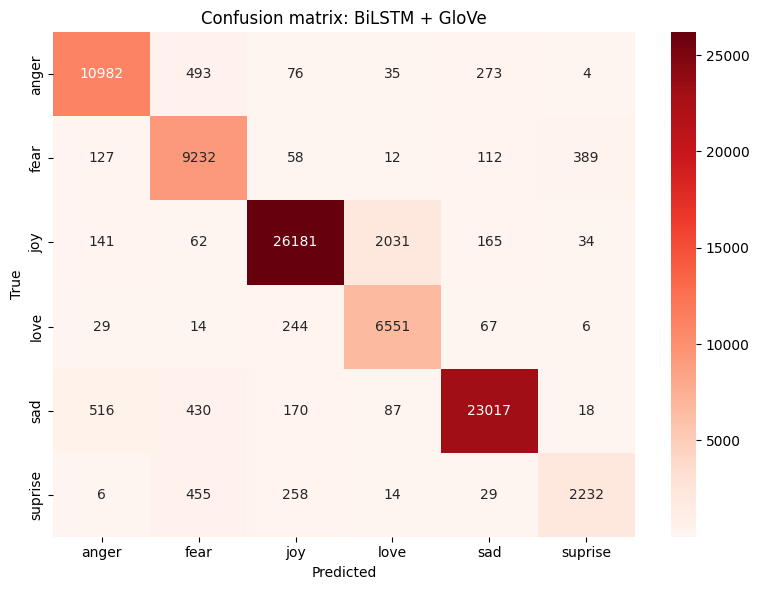

In [36]:
# Confusion matrix
cm = confusion_matrix(y_test_lstm, y_pred_lstmlabels)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix: BiLSTM + GloVe")
plt.tight_layout()
plt.show()

## **DistilBERT**

In [37]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Split data (stratified)

In [38]:
# Split into temp train (80%) and test (20%)
X_temp_dbert, X_test_dbert, y_temp_dbert, y_test_dbert = train_test_split(
    df_emotion_dl["clean_text"].tolist(),
    df_emotion_dl["label"].tolist(),
    stratify=df_emotion_dl["label"],
    test_size=0.2,
    random_state=SEED
)

# From temp train, split 87.5% train and 12.5% val (total: 70/10)
X_train_dbert, X_val_dbert, y_train_dbert, y_val_dbert = train_test_split(
    X_temp_dbert,
    y_temp_dbert,
    stratify=y_temp_dbert,
    test_size=0.125,
    random_state=SEED
)

### Compute class weights

In [39]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_dbert),
    y=y_train_dbert
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

### Tokenizer and dataset class

In [40]:
# Initialize tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenize class
def tokenize(texts):
  return tokenizer(texts, padding="max_length", truncation=True, max_length=128)

train_encodings = tokenize(X_train_dbert)
val_encodings = tokenize(X_val_dbert)
test_encodings = tokenize(X_test_dbert)

# Dataset class
class EmotionDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = EmotionDataset(train_encodings, y_train_dbert)
val_dataset = EmotionDataset(val_encodings, y_val_dbert)
test_dataset = EmotionDataset(test_encodings, y_test_dbert)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

### Model setup

In [41]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_mapping)
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Custom trainer to apply class weights

In [42]:
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

### Training arguments and trainer

In [43]:
training_args = TrainingArguments(
    output_dir="./results_distilbert",
    save_strategy="epoch",
    eval_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_steps=500,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True,
    report_to="none",
    lr_scheduler_type="linear",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    seed=SEED
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    class_weights=class_weights
)

### Train the model

In [44]:
start_train = time.time()
trainer.train()
train_time = round(time.time() - start_train, 2)

Epoch,Training Loss,Validation Loss
1,0.103500,0.110434
2,0.120200,0.105908
3,0.100700,0.108983
4,0.095200,0.111973


### Evaluation

In [45]:
# Predict
preds_output = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(preds_output.predictions), axis=1).numpy()

# Evaluation metrics
acc = accuracy_score(y_test_dbert, preds)
prec = precision_score(y_test_dbert, preds, average="macro")
rec = recall_score(y_test_dbert, preds, average="macro")
f1 = f1_score(y_test_dbert, preds, average="macro")

print("\nDistilBERT")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Time:      {train_time} seconds\n")
print("Classification Report:\n", classification_report(y_test_dbert, preds, target_names=le.classes_))

# Save results for summary
dbert_results = []
dbert_results.append({
    "Model": "DistilBERT",
    "Vectorization": "DistilBERT",
    "F1": round(f1, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4),
    "Accuracy": round(acc, 4),
    "Time (s)": train_time
})


DistilBERT
Accuracy:  0.9434
Precision: 0.8929
Recall:    0.9568
F1-score:  0.9189
Time:      709.8 seconds

Classification Report:
               precision    recall  f1-score   support

       anger       0.94      0.96      0.95     11863
        fear       0.91      0.91      0.91      9930
         joy       1.00      0.92      0.96     28614
        love       0.78      1.00      0.87      6911
         sad       1.00      0.96      0.98     24238
     suprise       0.74      1.00      0.85      2994

    accuracy                           0.94     84550
   macro avg       0.89      0.96      0.92     84550
weighted avg       0.95      0.94      0.95     84550



### Confusion matrix

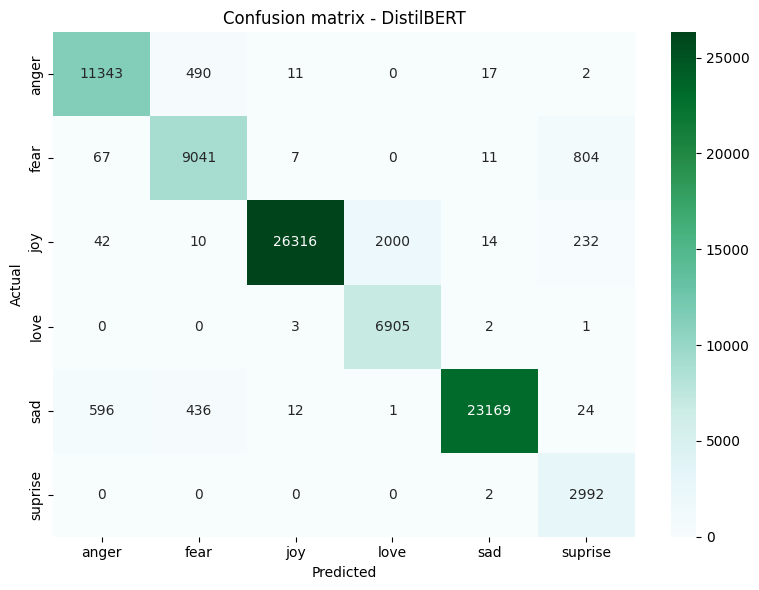

In [46]:
# Confusion matrix
cm = confusion_matrix(y_test_dbert, preds)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix - DistilBERT")
plt.tight_layout()
plt.show()

## **Summary of results (all models)**



In [47]:
# Combine all results
all_model_results = (
    svm_results +
    lr_results +
    nb_results +
    mlp_results +
    lstm_results +
    dbert_results
)

# Create DataFrame
results_df = pd.DataFrame(all_model_results)

# Sort
results_df = results_df.sort_index()

# Print as markdown table
print(tabulate(results_df, headers='keys', tablefmt='github'))

|    | Model               | Vectorization   | F1     | Precision   | Recall   | Accuracy   | Time (s)   |
|----|---------------------|-----------------|--------|-------------|----------|------------|------------|
|  0 | LinearSVC           | TF-IDF          | 0.9216 | 0.9229      | 0.9219   | 0.9219     | 7.11       |
|  1 | LinearSVC           | BoW             | 0.9159 | 0.9167      | 0.9163   | 0.9163     | 16.33      |
|  2 | LinearSVC           | SBERT (scaled)  | 0.6849 | 0.6855      | 0.6865   | 0.6865     | 149.11     |
|  3 | Logistic Regression | BoW             | 0.9131 | 0.9142      | 0.9135   | 0.9135     | 22.24      |
|  4 | Logistic Regression | TF-IDF          | 0.9127 | 0.9134      | 0.913    | 0.913      | 34.57      |
|  5 | Logistic Regression | SBERT (scaled)  | 0.6858 | 0.6856      | 0.6865   | 0.6865     | 25.78      |
|  6 | Naive Bayes         | BoW             | 0.8921 | 0.8936      | 0.8925   | 0.8925     | 0.25       |
|  7 | Naive Bayes         | TF-IDF  

## Print misclassified examples LinearSVC+TF-IDF and DistilBERT

### LinearSVC+TF-IDF

In [48]:
misclassified_svm_tfidf = [
    (text, true, pred)
    for text, true, pred in zip(X_test, y_test, svm_tfidf_preds)
    if true != pred
]
for i in range(5):
    print(f"\nText: {misclassified_svm_tfidf[i][0]}")
    print(f"True: {le.inverse_transform([misclassified_svm_tfidf[i][1]])[0]}")
    print(f"Pred: {le.inverse_transform([misclassified_svm_tfidf[i][2]])[0]}")


Text: feeling lot meeting frantic email texte stressed shit go work angry manage fall day two bother address
True: fear
Pred: anger

Text: like think quite thrifty come nail polish buying every often feel like splurge something amazing get dupe cheap
True: joy
Pred: suprise

Text: loss close relative ill cancer
True: sad
Pred: fear

Text: often think people would rather shocked know often think miss feel loss sweet girl
True: joy
Pred: love

Text: need joy life feel really agitated unsettle work need get clear goal make change
True: anger
Pred: fear


### DistilBERT

In [49]:
misclassified_dbert = [
    (text, true, pred)
    for text, true, pred in zip(X_val_dbert, y_val_dbert, preds)
    if true != pred
]
for i in range(5):
    print(f"\nText: {misclassified_dbert[i][0]}")
    print(f"True: {le.inverse_transform([misclassified_dbert[i][1]])[0]}")
    print(f"Pred: {le.inverse_transform([misclassified_dbert[i][2]])[0]}")


Text: i don t even feel burdened
True: sad
Pred: joy

Text: i feel that is a useless way to begin the statement
True: sad
Pred: joy

Text: i often feel rushed
True: anger
Pred: sad

Text: i go about every fifteen minutes and do not feel well at all
True: joy
Pred: sad

Text: i feel a sweet and soft touch on my lips a kiss
True: love
Pred: anger


# **Cross-task generalization**
Emotion prediction, using LinearSVC+TF-IDF, on unseen sentiment-based data

## Load dataset

In [50]:
df_sentiment = pd.read_csv("combined_sentiment_data.csv")

# Preview
print("Shape:", df_sentiment.shape)
df_sentiment.head()

Shape: (3309, 2)


,sentence,sentiment
0,So there is no way for me to plug it in here i...,negative
1,"Good case, Excellent value.",positive
2,Great for the jawbone.,positive
3,Tied to charger for conversations lasting more...,negative
4,The mic is great.,positive


## Basic information

In [51]:
# Basic info
df_sentiment.info()

# Check for missing values
print("\nMissing values per column:\n", df_sentiment.isnull().sum())

# Unique emotion labels
print("\nUnique sentiment labels:", df_sentiment['sentiment'].unique())
print("\nSentiment label distribution:\n", df_sentiment['sentiment'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   3309 non-null   object
 1   sentiment  3309 non-null   object
dtypes: object(2)
memory usage: 51.8+ KB

Missing values per column:
 sentence     0
sentiment    0
dtype: int64

Unique sentiment labels: ['negative' 'positive']

Sentiment label distribution:
 sentiment
positive    1679
negative    1630
Name: count, dtype: int64


## Basic preprocessing (reusing pipeline)

In [52]:
# Reuse cleaning
df_sentiment["clean_text"] = df_sentiment["sentence"].apply(clean_text)

# Reuse lemmatization for consistency
texts_sent = df_sentiment["clean_text"].astype(str).tolist()
df_sentiment["lemmatized"] = fast_lemmatize_texts(texts_sent, stop_words)

### Check preprocessing

In [53]:
# Show some examples where original != cleaned
df_sentiment[df_sentiment["sentence"] != df_sentiment["clean_text"]][["sentence", "clean_text"]].head()

,sentence,clean_text
0,So there is no way for me to plug it in here i...,so there is no way for me to plug it in here i...
1,"Good case, Excellent value.",good case excellent value
2,Great for the jawbone.,great for the jawbone
3,Tied to charger for conversations lasting more...,tied to charger for conversations lasting more...
4,The mic is great.,the mic is great


## Vectorize using trained TF-IDF

In [54]:
# Use lemmatized text from sentiment dataset
X_sentiment_texts = df_sentiment["lemmatized"]

# Transform using trained TF-IDF vectorizer
X_sentiment_tfidf = tfidf_vectorizer.transform(X_sentiment_texts)

## Predict using trained best SVM model

In [55]:
# Predict on new data using the trained best_model
sentiment_preds = best_svm_model_tfidf.predict(X_sentiment_tfidf)

# Store results
df_sentiment["predicted_emotion"] = sentiment_preds
df_sentiment["predicted_emotion_label"] = le.inverse_transform(sentiment_preds)

## Visualize prediction distribution

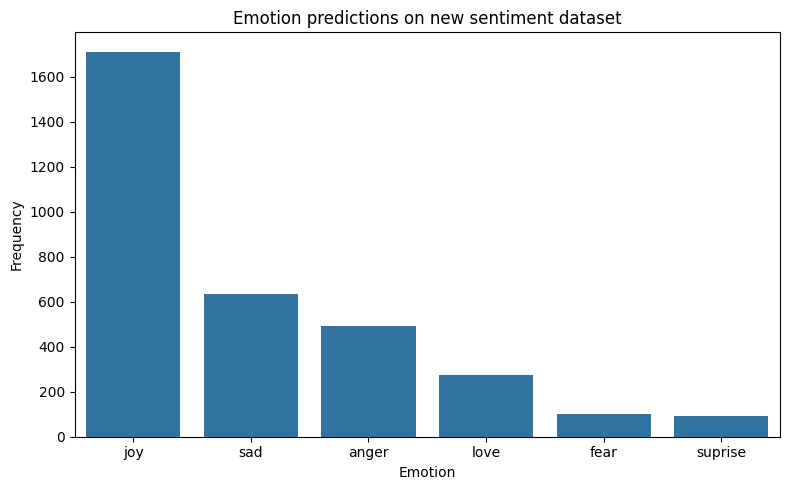

In [56]:
plt.figure(figsize=(8, 5))
emotion_counts = df_sentiment["predicted_emotion_label"].value_counts().sort_values(ascending=False)
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title("Emotion predictions on new sentiment dataset")
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Preview predictions

In [59]:
# View a few random predictions
df_sentiment[["clean_text", "predicted_emotion_label"]].sample(10)

,clean_text,predicted_emotion_label
3058,highfrequency trading algorithms can exacerbat...,fear
2498,their monster chicken fried steak and eggs is ...,joy
360,nice design and quality,joy
1257,it was so funny,suprise
3032,education should empower students to become li...,anger
932,down the drain because of a weak snap,sad
1090,definitely worth checking out,love
2270,the veggitarian platter is out of this world,joy
3285,space weather phenomena such as solar flares a...,anger
2606,it was awesome,joy


## Cluster sentences by predicted emotion

In [60]:
for emotion in df_sentiment["predicted_emotion_label"].unique():
    print(f"\n--- {emotion.upper()} ---")
    print(df_sentiment[df_sentiment["predicted_emotion_label"] == emotion]["clean_text"].sample(3).tolist())


--- JOY ---
['good case excellent value', 'privatization efforts in education prioritize profit over student wellbeing', 'financial institutions play a crucial role in allocating capital and facilitating economic activity']

--- ANGER ---
['do not waste your time here', 'their onscreen chemistry critical to the entire film is genuine', 'never had anything to complain about here']

--- SAD ---
['great service and food', 'bought mainly for the charger which broke soon after purchasing', 'useless phone simply deaf']

--- SUPRISE ---
['very funny', 'i was shocked because no signs indicate cash only', 'this film offers many delights and surprises']

--- LOVE ---
['nice spicy and tender', 'special education programs strive to support diverse learners but funding often falls short', 'i have only had my bluetooth for a few weeks but i really like it']

--- FEAR ---
['the pressure to succeed in sports can have detrimental effects on mental health', 'political polarization threatens to tear apa